# Saving multilevel HEALPix Data in zarr and datatree 

In this notebook, we will demonstrate  examples of saving multilevel HEALPix data.  

## Setup

To run this notebook, you need to install XDGGS. You can find the xdggs repository here: [XDGGS GitHub Repository](https://github.com/xarray-contrib/xdggs.git).


1. You can either install `xdggs` with the necessary dependencies, use the following command:

```bash
pip install xdggs
```

2. You will need up to date xarray package :

```bash
pip install -U xarray
```

3. You can use zarr version zarr==2.18.4.  In a few weeks, it would work with icechunk as well. :

```bash
#pip install icechunk
pip install -U zarr==2.18.4
```


In [ ]:
#!pip install xdggs pint_xarray icechunk
!pip install xdggs
#!pip install icechunk
!pip install -U zarr==2.18.4

In [ ]:
!pip install -U xarray

In [1]:
import warnings

import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xdggs

warnings.filterwarnings("ignore")

In [2]:
xr.__version__

'2024.11.0'

In [3]:
import zarr

zarr.__version__

'2.18.4'

##  Creating level8 Healpix dataset 
HEALPix is designed to represent the sphere using spherical harmonics functions.
Following code with generate a test dateset. 

chunk_size_8 4096


<xarray.Dataset> Size: 25MB
Dimensions:    (cells: 786432)
Coordinates:
  * cell_ids   (cells) int64 6MB dask.array<chunksize=(4096,), meta=np.ndarray>
    latitude   (cells) float64 6MB dask.array<chunksize=(4096,), meta=np.ndarray>
    longitude  (cells) float64 6MB dask.array<chunksize=(4096,), meta=np.ndarray>
Dimensions without coordinates: cells
Data variables:
    data       (cells) float64 6MB dask.array<chunksize=(4096,), meta=np.ndarray>
Indexes:
    cell_ids  HealpixIndex(nside=8, indexing_scheme=nested)

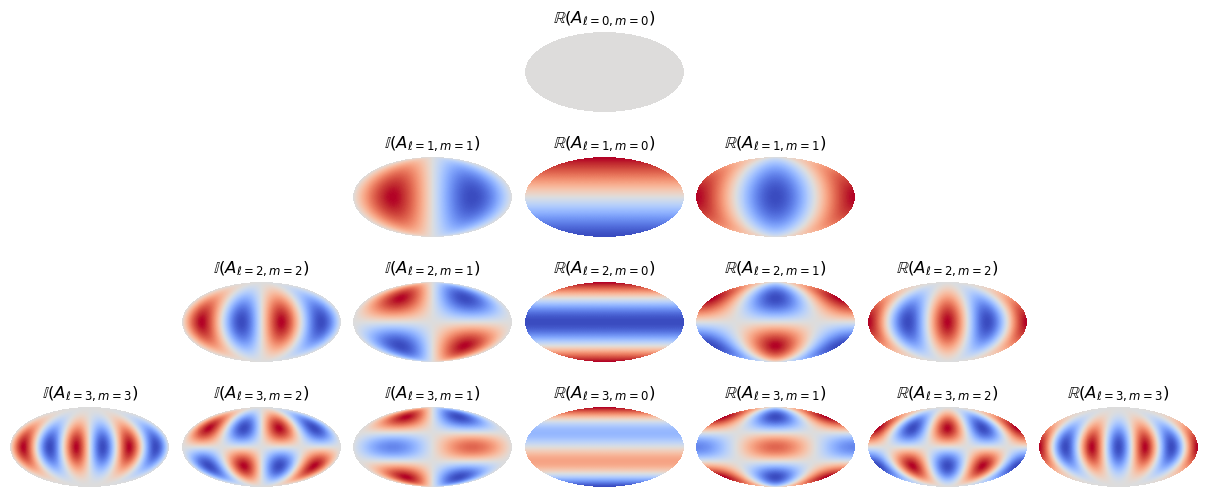

In [4]:
lmax = 3
level = 8
nside = 2**level
# compute Alm
# get the l and m availble for l<=lmax
l, m = hp.Alm.getlm(lmax=lmax)  # noqa: E741

# count the number of alm map (1 for m=0 and 2 for m>0)
n_alm = (m == 0).sum() + 2 * (m > 0).sum()
function = np.zeros([n_alm, 12 * nside**2])

alm = np.zeros([l.shape[0]], dtype="complex")

i = 0

# array to store the l and m values of the A_lm
l_func = np.zeros(n_alm, dtype="int")
m_func = np.zeros(n_alm, dtype="int")
is_real_func = np.zeros(n_alm, dtype="int")

for k in range(l.shape[0]):
    alm[k] = 1.0
    function[i] = hp.reorder(hp.alm2map(alm, nside), r2n=True)
    l_func[i] = l[k]
    m_func[i] = m[k]
    is_real_func[i] = 1
    i += 1
    if m[k] > 0:
        alm[k] = complex(0, 1)
        function[i] = hp.reorder(hp.alm2map(alm, nside), r2n=True)
        l_func[i] = l[k]
        m_func[i] = m[k]
        is_real_func[i] = 0
        i += 1
    alm[k] = 0.0
lm = 3
plt.figure(figsize=(12, 5))


for k in range(l_func.shape[0]):
    pos = (
        1
        + l_func[k] * (2 * lm + 1)
        + 2 * (is_real_func[k] - 0.5) * m_func[k]
        - 1
        + (lm + 1)
    )
    if is_real_func[k] == 1:
        title = "$\mathbb{R}(A_{\ell=%d,m=%d})$" % (l_func[k], m_func[k])
    else:
        title = "$\mathbb{I}(A_{\ell=%d,m=%d})$" % (l_func[k], m_func[k])
    if l_func[k] <= lm:
        hp.mollview(
            function[k],
            nest=True,
            hold=False,
            sub=(lm + 1, 2 * lm + 1, pos),
            title=title,
            cbar=False,
            cmap="coolwarm",
        )


level = 8
cell_ids = np.arange(12 * 4**level)
grid_info = {"grid_name": "healpix", "level": level, "indexing_scheme": "nested"}

ds_8 = (
    xr.Dataset(coords={"cell_ids": ("cells", cell_ids, grid_info)})
    .pipe(xdggs.decode)
    .pipe(lambda ds: ds.merge(ds.dggs.cell_centers()))
    .assign(
        data=lambda ds: np.cos(6 * np.radians(ds["latitude"]))
        * np.sin(6 * np.radians(ds["longitude"]))
    )
)
SH_L3_M2 = xr.DataArray(
    function[13, :], dims=("cells"), coords={"cell_ids": ("cells", cell_ids, grid_info)}
)
ds_8["data"] = SH_L3_M2
chunk_late = 12 * (4**2)
chunk_size_8 = int((ds_8.cells.size) / chunk_late)
print("chunk_size_8", chunk_size_8)
ds_8 = ds_8.chunk(chunks={"cells": chunk_size_8})
ds_8

##  Creating level7 Healpix dataset 
HEALPix is designed to represent the sphere using spherical harmonics functions.
Following code with generate a test dateset. 

chunk_size_7 1024


<xarray.Dataset> Size: 6MB
Dimensions:    (cells: 196608)
Coordinates:
  * cell_ids   (cells) int64 2MB dask.array<chunksize=(1024,), meta=np.ndarray>
    latitude   (cells) float64 2MB dask.array<chunksize=(1024,), meta=np.ndarray>
    longitude  (cells) float64 2MB dask.array<chunksize=(1024,), meta=np.ndarray>
Dimensions without coordinates: cells
Data variables:
    data       (cells) float64 2MB dask.array<chunksize=(1024,), meta=np.ndarray>
Indexes:
    cell_ids  HealpixIndex(nside=7, indexing_scheme=nested)

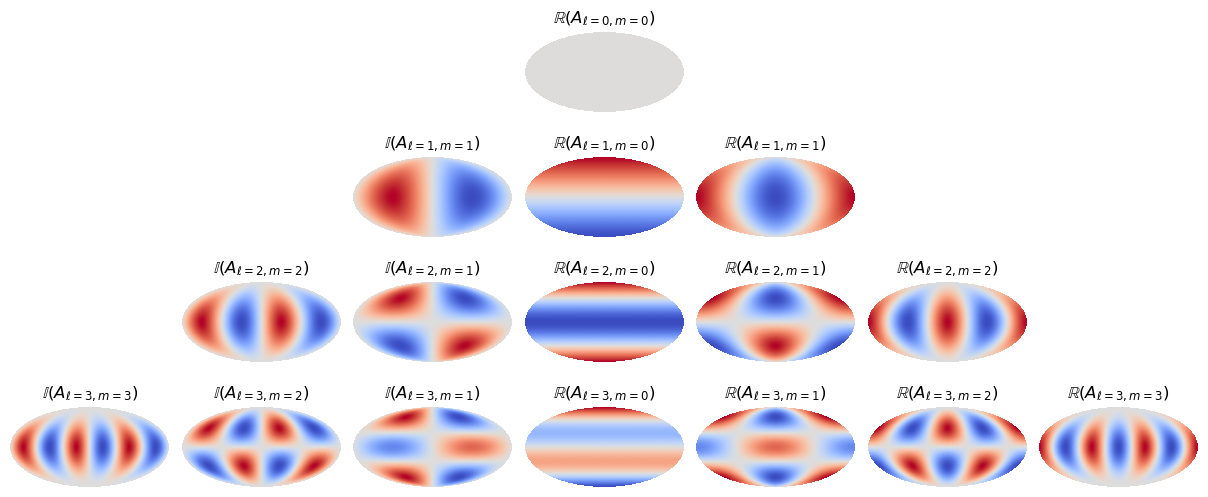

In [5]:
lmax = 3
level = 7
nside = 2**level
# compute Alm
# get the l and m availble for l<=lmax
l, m = hp.Alm.getlm(lmax=lmax)  # noqa: E741

# count the number of alm map (1 for m=0 and 2 for m>0)
n_alm = (m == 0).sum() + 2 * (m > 0).sum()
function = np.zeros([n_alm, 12 * nside**2])

alm = np.zeros([l.shape[0]], dtype="complex")

i = 0

# array to store the l and m values of the A_lm
l_func = np.zeros(n_alm, dtype="int")
m_func = np.zeros(n_alm, dtype="int")
is_real_func = np.zeros(n_alm, dtype="int")

for k in range(l.shape[0]):
    alm[k] = 1.0
    function[i] = hp.reorder(hp.alm2map(alm, nside), r2n=True)
    l_func[i] = l[k]
    m_func[i] = m[k]
    is_real_func[i] = 1
    i += 1
    if m[k] > 0:
        alm[k] = complex(0, 1)
        function[i] = hp.reorder(hp.alm2map(alm, nside), r2n=True)
        l_func[i] = l[k]
        m_func[i] = m[k]
        is_real_func[i] = 0
        i += 1
    alm[k] = 0.0
lm = 3
plt.figure(figsize=(12, 5))
for k in range(l_func.shape[0]):
    pos = (
        1
        + l_func[k] * (2 * lm + 1)
        + 2 * (is_real_func[k] - 0.5) * m_func[k]
        - 1
        + (lm + 1)
    )
    if is_real_func[k] == 1:
        title = "$\mathbb{R}(A_{\ell=%d,m=%d})$" % (l_func[k], m_func[k])
    else:
        title = "$\mathbb{I}(A_{\ell=%d,m=%d})$" % (l_func[k], m_func[k])
    if l_func[k] <= lm:
        hp.mollview(
            function[k],
            nest=True,
            hold=False,
            sub=(lm + 1, 2 * lm + 1, pos),
            title=title,
            cbar=False,
            cmap="coolwarm",
        )


cell_ids = np.arange(12 * 4**level)
grid_info = {"grid_name": "healpix", "level": level, "indexing_scheme": "nested"}

ds_7 = (
    xr.Dataset(coords={"cell_ids": ("cells", cell_ids, grid_info)})
    .pipe(xdggs.decode)
    .pipe(lambda ds: ds.merge(ds.dggs.cell_centers()))
    .assign(
        data=lambda ds: np.cos(6 * np.radians(ds["latitude"]))
        * np.sin(6 * np.radians(ds["longitude"]))
    )
)
SH_L3_M2 = xr.DataArray(
    function[13, :], dims=("cells"), coords={"cell_ids": ("cells", cell_ids, grid_info)}
)
ds_7["data"] = SH_L3_M2
chunk_late = 12 * (4**2)
chunk_size_7 = int((ds_7.cells.size) / chunk_late)
print("chunk_size_7", chunk_size_7)
ds_7 = ds_7.chunk(chunks={"cells": chunk_size_7})
ds_7

## Open a EERIE Cloud  data in hearlpix, saved in zarr format from DKRZ, and importing the level9 dataset

NextGems project provide their data set in healpix in zarr format. 
Deatiled description of EERIE Cloud can be found here
https://easy.gems.dkrz.de/simulations/EERIE/eerie_data-access_online.html


I just want to show how to save sahred dimention or coordinate system between different levels here,

I get time coordinate from this dataset as a test, saved it as 'root' 

In [6]:
ds = xr.open_dataset(
    "https://eerie.cloud.dkrz.de/datasets/nextgems.IFS_9-FESOM_5-production.2D_hourly_healpix512/zarr",
    engine="zarr",
    chunks={},
    consolidated=True,
)
ds = (
    ds[["msl"]]
    .rename_dims({"value": "cells"})
    .assign_coords(
        cell_ids=(
            "cells",
            np.arange(12 * 4**9),
            {"grid_name": "healpix", "level": 9, "indexing_scheme": "nested"},
        )
    )
    .pipe(xdggs.decode)
)

chunk_late = 12 * (4**2)
chunk_size_9 = int((ds.cells.size) / chunk_late)
# print("chunk_size_9", chunk_size_9)
ds = ds.isel(cells=slice(0, 4 * chunk_size_9), time=slice(0, 2))
# ds = ds.chunk(chunks={"cells": chunk_size_9})
ds

<xarray.Dataset> Size: 3MB
Dimensions:   (time: 2, cells: 65536)
Coordinates:
    lat       (cells) float64 524kB dask.array<chunksize=(65536,), meta=np.ndarray>
    lon       (cells) float64 524kB dask.array<chunksize=(65536,), meta=np.ndarray>
  * time      (time) datetime64[ns] 16B 2020-01-20 2020-01-20T01:00:00
  * cell_ids  (cells) int64 524kB 0 1 2 3 4 5 ... 65531 65532 65533 65534 65535
Dimensions without coordinates: cells
Data variables:
    msl       (time, cells) float64 1MB dask.array<chunksize=(2, 65536), meta=np.ndarray>
Indexes:
    cell_ids  HealpixIndex(nside=9, indexing_scheme=nested)
Attributes: (12/14)
    edition:            2
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          1003
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...
    title:              nextgems.IFS_9-FESOM_5-production.2D_hourly_healpix512
    ...                 ...
    time_max:           2050-01-01T00:00:00.000000000
    frequency:          unknown
    creation_date:      2024-12-14T00:01:16Z
    authors:            Wieners, Karl-Hermann (MPIMet), Aguridan, Razvan (ECM...
    contact:            Wieners, Karl-Hermann (MPIMet), Rackow, Thomas (ECMWF)
    license:            Creative Commons Attribution 4.0 International (CC BY...

In [ ]:
ds = ds.sel(cell_ids=slice(0, chunk_size_9 * 4)).isel(
    time=slice(0, 2)
)  # .dggs.explore(cmap="viridis", alpha=0.8)  # center=0,

In [7]:
root = xr.Dataset(coords={"time": ds.coords["time"]})

## Create a datatree including different levels of HEALPix data



In [8]:
plevels = {"/": root, "9": ds, "8": ds_8, "7": ds_7}

In [9]:
ds_all = xr.DataTree.from_dict(plevels)
ds_all

<xarray.DataTree>
Group: /
│   Dimensions:  (time: 2)
│   Coordinates:
│     * time     (time) datetime64[ns] 16B 2020-01-20 2020-01-20T01:00:00
├── Group: /9
│       Dimensions:   (time: 2, cells: 65536)
│       Coordinates:
│           lat       (cells) float64 524kB dask.array<chunksize=(65536,), meta=np.ndarray>
│           lon       (cells) float64 524kB dask.array<chunksize=(65536,), meta=np.ndarray>
│         * cell_ids  (cells) int64 524kB 0 1 2 3 4 5 ... 65531 65532 65533 65534 65535
│       Dimensions without coordinates: cells
│       Data variables:
│           msl       (time, cells) float64 1MB dask.array<chunksize=(2, 65536), meta=np.ndarray>
│       Indexes:
│           cell_ids  HealpixIndex(nside=9, indexing_scheme=nested)
│       Attributes: (12/14)
│           edition:            2
│           centre:             ecmf
│           centreDescription:  European Centre for Medium-Range Weather Forecasts
│           subCentre:          1003
│           history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...
│           title:              nextgems.IFS_9-FESOM_5-production.2D_hourly_healpix512
│           ...                 ...
│           time_max:           2050-01-01T00:00:00.000000000
│           frequency:          unknown
│           creation_date:      2024-12-14T00:01:16Z
│           authors:            Wieners, Karl-Hermann (MPIMet), Aguridan, Razvan (ECM...
│           contact:            Wieners, Karl-Hermann (MPIMet), Rackow, Thomas (ECMWF)
│           license:            Creative Commons Attribution 4.0 International (CC BY...
├── Group: /8
│       Dimensions:    (cells: 786432)
│       Coordinates:
│         * cell_ids   (cells) int64 6MB dask.array<chunksize=(4096,), meta=np.ndarray>
│           latitude   (cells) float64 6MB dask.array<chunksize=(4096,), meta=np.ndarray>
│           longitude  (cells) float64 6MB dask.array<chunksize=(4096,), meta=np.ndarray>
│       Dimensions without coordinates: cells
│       Data variables:
│           data       (cells) float64 6MB dask.array<chunksize=(4096,), meta=np.ndarray>
│       Indexes:
│           cell_ids  HealpixIndex(nside=8, indexing_scheme=nested)
└── Group: /7
        Dimensions:    (cells: 196608)
        Coordinates:
          * cell_ids   (cells) int64 2MB dask.array<chunksize=(1024,), meta=np.ndarray>
            latitude   (cells) float64 2MB dask.array<chunksize=(1024,), meta=np.ndarray>
            longitude  (cells) float64 2MB dask.array<chunksize=(1024,), meta=np.ndarray>
        Dimensions without coordinates: cells
        Data variables:
            data       (cells) float64 2MB dask.array<chunksize=(1024,), meta=np.ndarray>
        Indexes:
            cell_ids  HealpixIndex(nside=7, indexing_scheme=nested)

## Save it to zarr


In [10]:
ds_all.to_zarr("tree.zarr", mode="w")

### Plotting with xdggs is very simple, just use 'explore' function

In [11]:
data = xr.open_datatree("tree.zarr")
data
test = data["9"]["msl"].isel(time=0).compute()
# test = data["7"]["data"].compute()

In [36]:
map2 = test.pipe(xdggs.decode).dggs.explore(center=0, cmap="coolwarm", alpha=0.8)

### Selecting region to plot
#### Selection using healpix cell_ids

In [15]:
data

<xarray.DataTree>
Group: /
│   Dimensions:  (time: 2)
│   Coordinates:
│     * time     (time) datetime64[ns] 16B 2020-01-20 2020-01-20T01:00:00
├── Group: /7
│       Dimensions:    (cells: 196608)
│       Coordinates:
│           cell_ids   (cells) int64 2MB ...
│           latitude   (cells) float64 2MB ...
│           longitude  (cells) float64 2MB ...
│       Dimensions without coordinates: cells
│       Data variables:
│           data       (cells) float64 2MB ...
├── Group: /8
│       Dimensions:    (cells: 786432)
│       Coordinates:
│           cell_ids   (cells) int64 6MB 0 1 2 3 4 ... 786428 786429 786430 786431
│           latitude   (cells) float64 6MB ...
│           longitude  (cells) float64 6MB ...
│       Dimensions without coordinates: cells
│       Data variables:
│           data       (cells) float64 6MB ...
└── Group: /9
        Dimensions:   (cells: 65536, time: 2)
        Coordinates:
            cell_ids  (cells) int64 524kB ...
            lat       (cells) float64 524kB ...
            lon       (cells) float64 524kB ...
        Dimensions without coordinates: cells
        Data variables:
            msl       (time, cells) float64 1MB ...
        Attributes: (12/14)
            authors:            Wieners, Karl-Hermann (MPIMet), Aguridan, Razvan (ECM...
            centre:             ecmf
            centreDescription:  European Centre for Medium-Range Weather Forecasts
            contact:            Wieners, Karl-Hermann (MPIMet), Rackow, Thomas (ECMWF)
            creation_date:      2024-12-14T00:01:16Z
            description:        Simulation data from project 'not Set' produced by Ea...
            ...                 ...
            history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...
            license:            Creative Commons Attribution 4.0 International (CC BY...
            subCentre:          1003
            time_max:           2050-01-01T00:00:00.000000000
            time_min:           2020-01-20T00:00:00.000000000
            title:              nextgems.IFS_9-FESOM_5-production.2D_hourly_healpix512

In [23]:
(
    data["7"]
    .ds.pipe(xdggs.decode)
    .sel(cell_ids=slice(11000, 11100))["data"]
    .dggs.explore(cmap="viridis", alpha=0.8)
)

Map(layers=[SolidPolygonLayer(filled=True, get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x7f6e3b24…

In [13]:
(
    data["8"]
    .ds.pipe(xdggs.decode)
    .sel(cell_ids=slice(0, 1000))["data"]
    .dggs.explore(cmap="viridis", alpha=0.8)
)

Map(layers=[SolidPolygonLayer(filled=True, get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x7f6e287d…

#### Selection using latitude and longitude

In [22]:
(
    data["7"].ds.pipe(xdggs.decode).dggs.sel_latlon(latitude=48, longitude=0)["data"]
).dggs.explore(center=0, cmap="viridis", alpha=0.8)

Map(layers=[SolidPolygonLayer(filled=True, get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x7f6e3b6b…

In [28]:
(
    data["8"]
    .ds["data"]
    .pipe(xdggs.decode)
    .dggs.sel_latlon(longitude=[48, 47, 46], latitude=[-5, -5.3, -5.5])
).dggs.explore(center=0, cmap="viridis", alpha=0.8)

Map(layers=[SolidPolygonLayer(filled=True, get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x7f6dfe74…

In [35]:
lat = np.arange(48.5, 49, 0.01)
lon = np.arange(0, 1, 0.01)
full_lat = np.repeat(lat, len(lon))
full_lon = np.tile(lon, len(lat))

map1 = (
    data["8"]
    .ds["data"]
    .pipe(xdggs.decode)
    .dggs.sel_latlon(longitude=full_lon, latitude=full_lat)
).dggs.explore(center=0, cmap="viridis", alpha=0.8)

## Current Issue with Testing Different Datatree

The levels exist “outside” the dataset, rather than being part of each coordinate, dimension, or data array. For me, this feels strange, as I believe levels should be integrated into each coordinate, dimension, or data array.
This is because we are re-using the Datatree concept, which may need improvement in future.  


## Whats next

Plot different levels in a same figure using lonboard.


In [51]:
import numpy as np


def create_arrow_table(polygons, arr, coords=None):
    from arro3.core import Array, ChunkedArray, Schema, Table

    if coords is None:
        coords = ["latitude", "longitude"]

    array = Array.from_arrow(polygons)
    name = arr.name or "data"
    arrow_arrays = {
        "geometry": array,
        "cell_ids": ChunkedArray([Array.from_numpy(arr.coords["cell_ids"])]),
        name: ChunkedArray([Array.from_numpy(arr.data)]),
    } | {
        coord: ChunkedArray([Array.from_numpy(arr.coords[coord].data)])
        for coord in coords
        if coord in arr.coords
    }

    fields = [array.field.with_name(name) for name, array in arrow_arrays.items()]
    schema = Schema(fields)

    return Table.from_arrays(list(arrow_arrays.values()), schema=schema)


def normalize(var, center=None):
    from matplotlib.colors import CenteredNorm, Normalize

    if center is None:
        vmin = var.min(skipna=True)
        vmax = var.max(skipna=True)
        normalizer = Normalize(vmin=vmin, vmax=vmax)
    else:
        halfrange = np.abs(var - center).max(skipna=True)
        normalizer = CenteredNorm(vcenter=center, halfrange=halfrange)

    return normalizer(var.data)


def exploire_layer(
    arr,
    cell_dim="cells",
    cmap="viridis",
    center=None,
    alpha=None,
):
    from lonboard import SolidPolygonLayer
    from lonboard.colormap import apply_continuous_cmap
    from matplotlib import colormaps

    if len(arr.dims) != 1 or cell_dim not in arr.dims:
        raise ValueError(
            f"exploration only works with a single dimension ('{cell_dim}')"
        )

    cell_ids = arr.dggs.coord.data
    grid_info = arr.dggs.grid_info

    polygons = grid_info.cell_boundaries(cell_ids, backend="geoarrow")

    normalized_data = normalize(arr.variable, center=center)

    colormap = colormaps[cmap]
    colors = apply_continuous_cmap(normalized_data, colormap, alpha=alpha)

    table = create_arrow_table(polygons, arr)
    layer = SolidPolygonLayer(table=table, filled=True, get_fill_color=colors)

    return layer

In [63]:
import lonboard

arr = data["7"].ds.pipe(xdggs.decode).dggs.sel_latlon(latitude=48, longitude=0)["data"]
arr2 = data["8"].ds.pipe(xdggs.decode).dggs.sel_latlon(latitude=49, longitude=0)["data"]
arr3 = data["9"].isel(time=0).ds.pipe(xdggs.decode)["msl"]
lonboard.Map(
    [
        exploire_layer(arr2, alpha=0.8),
        exploire_layer(arr, alpha=0.5),
        exploire_layer(arr3, alpha=0.1),
    ]
)

Map(layers=[SolidPolygonLayer(filled=True, get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x7f6dfd19…

## Whats next

Use WW3 unstructured grid originated data